In [2]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

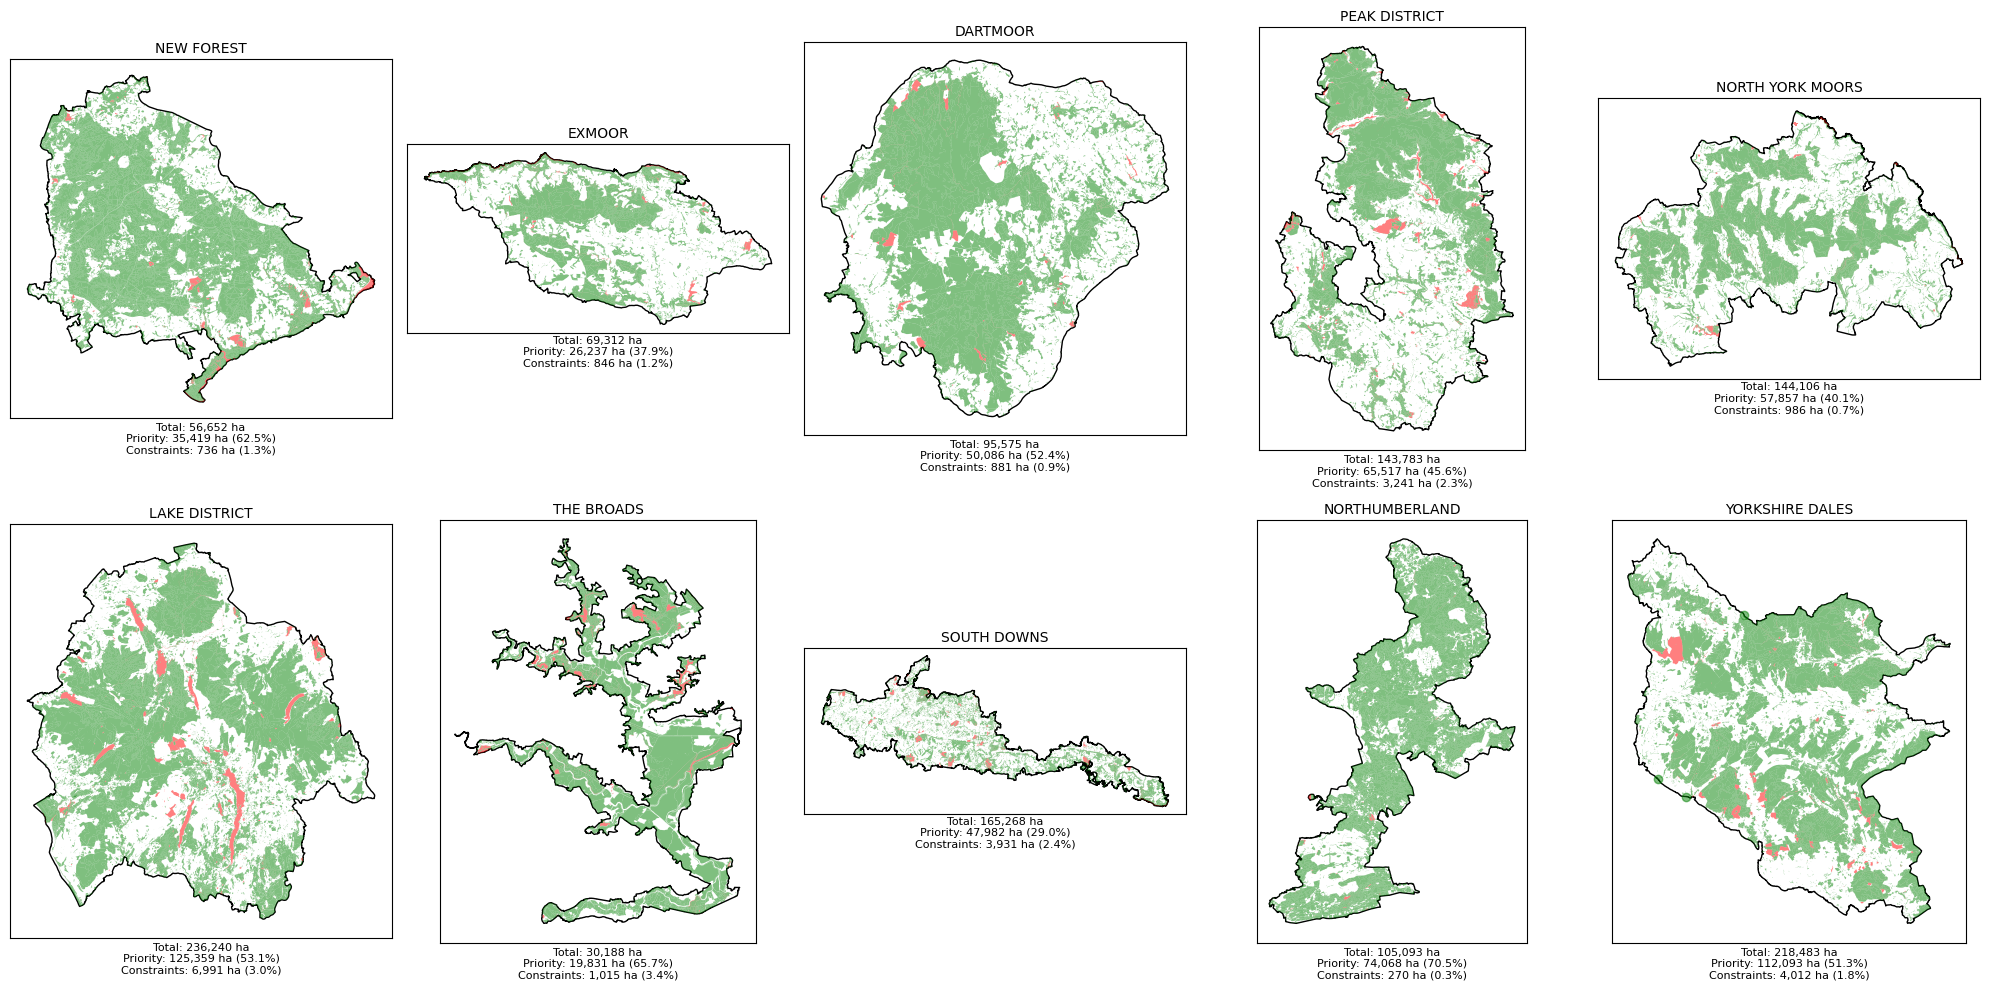

In [7]:
# File paths
boundary_path = "../data/boundaries/National_Parks_England/National_Parks_(England)___Natural_England.shp"
priority_habitats_path = "../data/outputs/clipped/priority_habitats_clipped.shp"
constraints_matrix_path = "../data/outputs/constraints_matrix/constraints_matrix_no_habitats.shp"

# Load GeoDataFrames
boundary_gdf = gpd.read_file(boundary_path).to_crs(epsg=27700)
priority_habitats_gdf = gpd.read_file(priority_habitats_path).to_crs(epsg=27700)
constraints_matrix_gdf = gpd.read_file(constraints_matrix_path).to_crs(epsg=27700)

# Add area calculation to each National Park
boundary_gdf["area_ha"] = boundary_gdf.geometry.area / 10000  # Convert to hectares

# Initialize a DataFrame to store areas
area_stats = []

# Loop through each National Park
for _, park in boundary_gdf.iterrows():
    park_geom = park.geometry
    park_name = park["NAME"]  # Adjust based on actual column name

    # Clip and calculate areas for Priority Habitats
    priority_clip = gpd.clip(priority_habitats_gdf, park_geom)
    priority_area_ha = priority_clip.geometry.area.sum() / 10000

    # Clip and calculate areas for Constraints Matrix
    constraints_clip = gpd.clip(constraints_matrix_gdf, park_geom)
    constraints_area_ha = constraints_clip.geometry.area.sum() / 10000

    # Append stats
    area_stats.append({
        "park_name": park_name,
        "total_area_ha": park["area_ha"],
        "priority_area_ha": priority_area_ha,
        "constraints_area_ha": constraints_area_ha,
        "priority_pct": (priority_area_ha / park["area_ha"]) * 100,
        "constraints_pct": (constraints_area_ha / park["area_ha"]) * 100
    })

# Convert area stats to a DataFrame
area_stats_df = pd.DataFrame(area_stats)

# Save stats to a CSV file
area_stats_df.to_csv("../output/national_parks_area_stats.csv", index=False)

# Plot National Parks with Subplots
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 rows, 5 columns
axes = axes.flatten()

for idx, (ax, park) in enumerate(zip(axes, boundary_gdf.iterrows())):
    _, park_data = park
    park_geom = park_data.geometry
    park_name = park_data["NAME"]

    # Plot the park boundary
    gpd.GeoSeries(park_geom).plot(ax=ax, color="none", edgecolor="black", linewidth=1)

    # Clip and plot priority habitats and constraints matrix
    gpd.clip(priority_habitats_gdf, park_geom).plot(ax=ax, color="green", alpha=0.5)
    gpd.clip(constraints_matrix_gdf, park_geom).plot(ax=ax, color="red", alpha=0.5)

    # Remove x and y axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Add title and stats below each subplot
    stats = area_stats_df[area_stats_df["park_name"] == park_name]
    annotation = (
        f"Total: {stats['total_area_ha'].values[0]:,.0f} ha\n"
        f"Priority: {stats['priority_area_ha'].values[0]:,.0f} ha "
        f"({stats['priority_pct'].values[0]:.1f}%)\n"
        f"Constraints: {stats['constraints_area_ha'].values[0]:,.0f} ha "
        f"({stats['constraints_pct'].values[0]:.1f}%)"
    )
    ax.set_title(park_name, fontsize=10, pad=5)
    ax.text(
        0.5, -0.01,  
        annotation,
        fontsize=8, ha="center", va="top", transform=ax.transAxes
    )

# Remove unused subplots if any
for idx in range(len(boundary_gdf), len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig("../output/national_parks_with_stats.png", dpi=300)
plt.show()

Statistics saved to: ../output/landcover_statistics_per_park.csv


/tmp/ipykernel_5148/924118638.py:70: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  improved_pasture_clip.plot(ax=ax, color="green", alpha=0.6, label="Improved Pasture")
/tmp/ipykernel_5148/924118638.py:71: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  broadleaved_woodland_clip.plot(ax=ax, color="red", alpha=0.6, label="Broadleaved Woodland")
/tmp/ipykernel_5148/924118638.py:71: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  broadleaved_woodland_clip.plot(ax=ax, color="red", alpha=0.6, label="Broadleaved Woodland")
/tmp/ipykernel_5148/924118638.py:71: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  broadleaved_woodland_clip.plot(ax=ax, color="red", alpha=0.6, label="Broadleaved Woodland")
/tmp/ipykernel_5148/924118638.py:71: UserWarning: The GeoDataFrame you are attempting to plot is empty

Plot saved to: ../output/national_parks_landcover_with_stats.png


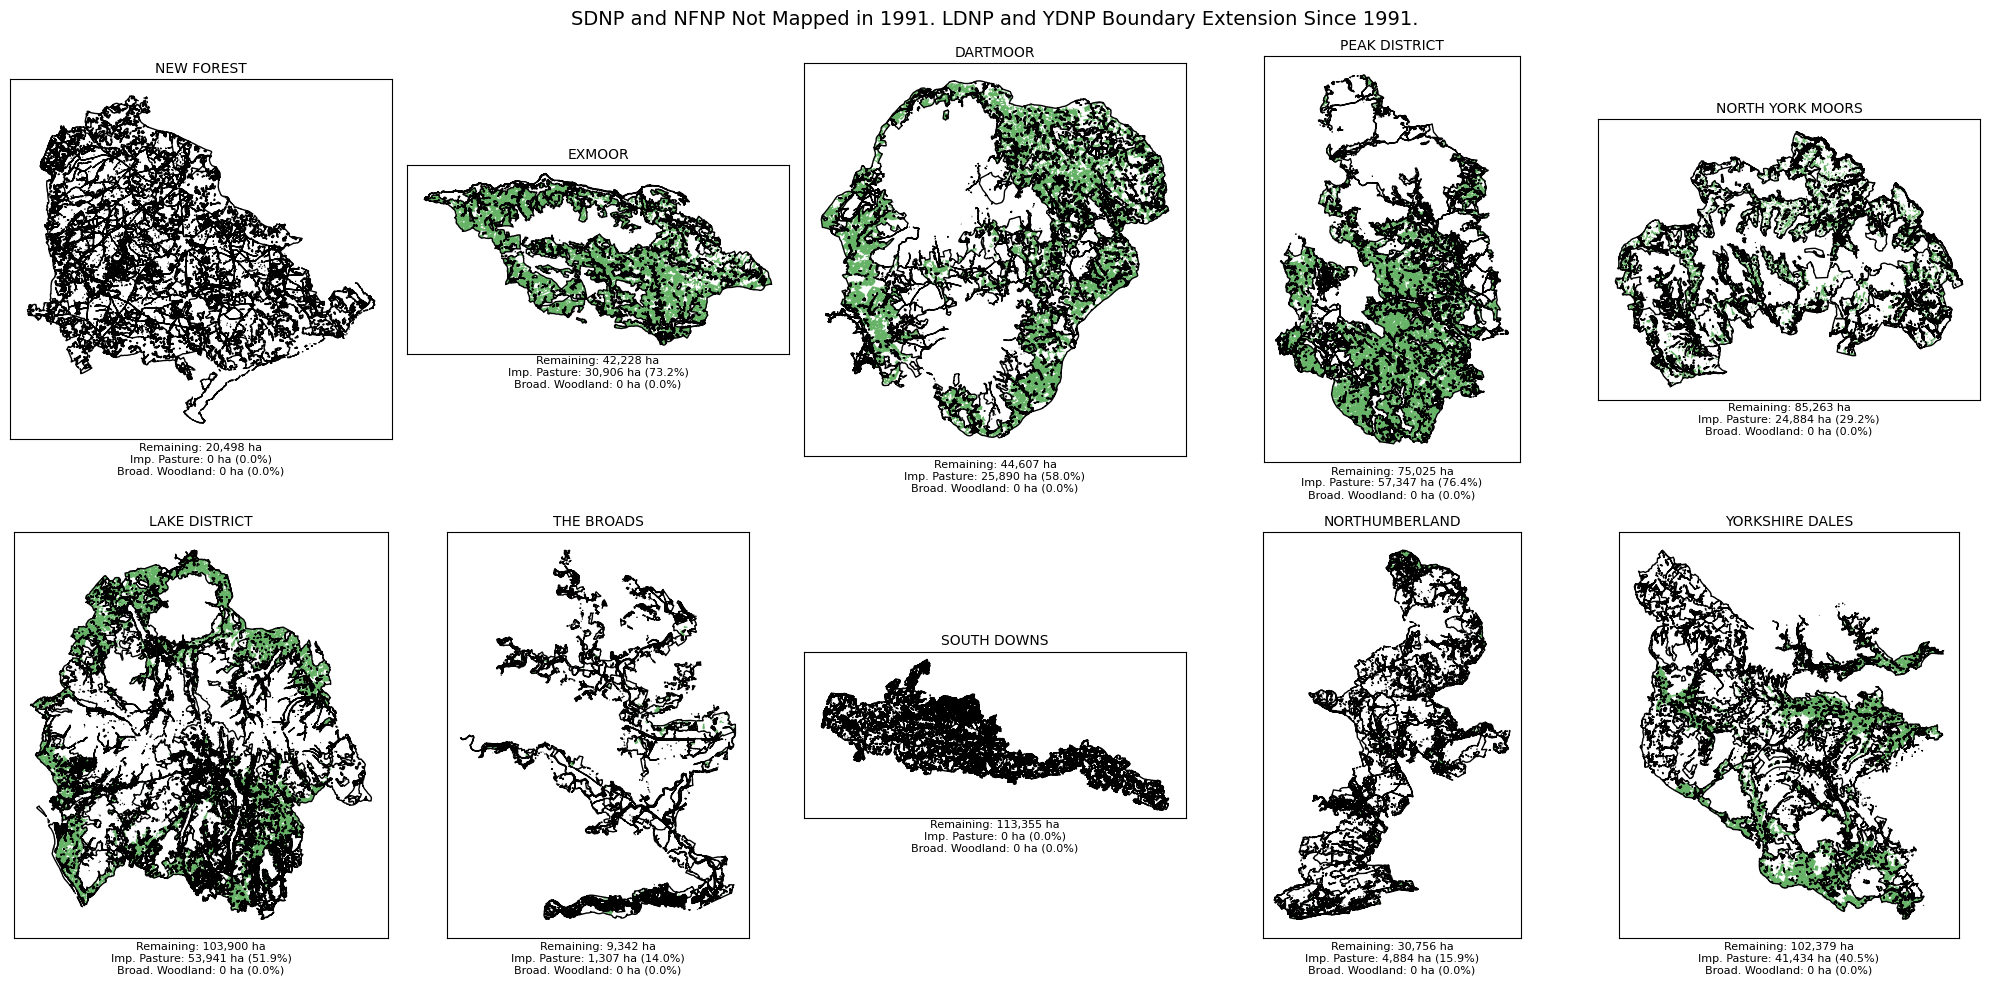

In [4]:
# File paths
boundary_path = "../data/boundaries/National_Parks_England/National_Parks_(England)___Natural_England.shp"
remaining_area_path = "../data/outputs/remaining_area.shp"
landcover_clipped_path = "../data/outputs/clipped/np_mos80a_Clip.shp"
output_csv_path = "../output/landcover_statistics_per_park.csv"
output_plot_path = "../output/national_parks_landcover_with_stats.png"

# Load GeoDataFrames
boundary_gdf = gpd.read_file(boundary_path).to_crs(epsg=27700)
remaining_area_gdf = gpd.read_file(remaining_area_path).to_crs(epsg=27700)
landcover_gdf = gpd.read_file(landcover_clipped_path).to_crs(epsg=27700)

# Add area calculation to remaining area
remaining_area_gdf["remaining_area_ha"] = remaining_area_gdf.geometry.area / 10000  # Convert to hectares

# Initialize a DataFrame to store results
area_stats = []

# Loop through each National Park
for _, park in remaining_area_gdf.iterrows():
    park_geom = park.geometry
    park_name = park["NAME"]  # Column for park names
    remaining_area_ha = park["remaining_area_ha"]

    # Clip 
    landcover_clip = gpd.clip(landcover_gdf, park_geom)
    landcover_clip["area_ha"] = landcover_clip.geometry.area / 10000  # Convert to hectares

    # Calculate stats for all `LEGEND_2` 
    legend2_stats = landcover_clip.groupby("LEGEND_2")["area_ha"].sum()

    # Get stats for "Improved Pasture" and "Broadleaved Woodland"
    improved_pasture_area = legend2_stats.get("Improved Pasture", 0)
    broadleaved_woodland_area = legend2_stats.get("Broadleaved Woodland", 0)

    # Append stats to the list
    area_stats.append({
        "park_name": park_name,
        "remaining_area_ha": remaining_area_ha,
        "improved_pasture_ha": improved_pasture_area,
        "improved_pasture_pct": (improved_pasture_area / remaining_area_ha) * 100 if remaining_area_ha > 0 else 0,
        "broadleaved_woodland_ha": broadleaved_woodland_area,
        "broadleaved_woodland_pct": (broadleaved_woodland_area / remaining_area_ha) * 100 if remaining_area_ha > 0 else 0,
        **{legend: area for legend, area in legend2_stats.items()}  # Add all LEGEND_2 areas
    })

# area stats 
area_stats_df = pd.DataFrame(area_stats)

# Save stats to a CSV 
area_stats_df.to_csv(output_csv_path, index=False)
print(f"Statistics saved to: {output_csv_path}")

# Plot with Subplots
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 rows, 5 columns
axes = axes.flatten()

for idx, (ax, park) in enumerate(zip(axes, remaining_area_gdf.iterrows())):
    _, park_data = park
    park_geom = park_data.geometry
    park_name = park_data["NAME"]

    # Clip and plot "Improved Pasture" and "Broadleaved Woodland"
    landcover_clip = gpd.clip(landcover_gdf, park_geom)
    landcover_clip["area_ha"] = landcover_clip.geometry.area / 10000

    # Plot "Improved Pasture" in green and "Broadleaved Woodland" in red
    improved_pasture_clip = landcover_clip[landcover_clip["LEGEND_2"] == "Improved Pasture"]
    broadleaved_woodland_clip = landcover_clip[landcover_clip["LEGEND_2"] == "Broadleaved Woodland"]
    improved_pasture_clip.plot(ax=ax, color="green", alpha=0.6, label="Improved Pasture")
    broadleaved_woodland_clip.plot(ax=ax, color="red", alpha=0.6, label="Broadleaved Woodland")

    # Plot the park boundary
    gpd.GeoSeries(park_geom).plot(ax=ax, color="none", edgecolor="black", linewidth=1)

    ax.set_xticks([])
    ax.set_yticks([])

    # Add title and stats 
    stats = area_stats_df[area_stats_df["park_name"] == park_name]
    annotation = (
        f"Remaining: {stats['remaining_area_ha'].values[0]:,.0f} ha\n"
        f"Imp. Pasture: {stats['improved_pasture_ha'].values[0]:,.0f} ha "
        f"({stats['improved_pasture_pct'].values[0]:.1f}%)\n"
        f"Broad. Woodland: {stats['broadleaved_woodland_ha'].values[0]:,.0f} ha "
        f"({stats['broadleaved_woodland_pct'].values[0]:.1f}%)"
    )
    ax.set_title(park_name, fontsize=10, pad=5)
    ax.text(
        0.5, -0.01,
        annotation,
        fontsize=8, ha="center", va="top", transform=ax.transAxes
    )

# Remove unused subplots if any
for idx in range(len(remaining_area_gdf), len(axes)):
    fig.delaxes(axes[idx])

# title
fig.suptitle(
    "SDNP and NFNP Not Mapped in 1991. LDNP and YDNP Boundary Extension Since 1991.",
    fontsize=14, y=0.98
)

# save the plot
plt.tight_layout()
plt.savefig(output_plot_path, dpi=300)
print(f"Plot saved to: {output_plot_path}")
plt.show()
